In [1]:
from project_3_indicator import run_calculation, get_calculation_cube_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Error initializing database: no such column: property_id
Error initializing database: no such column: property_id


In [18]:

def run_casscf_calculation():
    # Define scanning properties for y and z directions
    input = {
    "molecule": "ethene",
    "method": "CASSCF(2,2)",
    "basis": 'TZVP',
    "max_workers": 6,
    "grid": {'x':(3,0.1), 'y':(2,0.1), 'z':(0.0,0.0)},
    "properties": ['otr']
}

    # Run calculation for CASSCF(2,2) with scanning properties
    results = run_calculation(input)

    return results

In [19]:
results = run_casscf_calculation()

INFO:project_3_indicator.input.specification:Creating input specification for ethene with CASSCF(2,2)/TZVP
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:project_3_indicator.handler.calculation:Processing calculation for ethene with CASSCF(2,2)/TZVP
INFO:project_3_indicator.handler.calculation:Created new calculation with ID: 455985


Connected to atlas.
Geometry for ethene successfully loaded.
Method name: CASSCF(2,2) False
otr
['density', 'on_top']


ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/455985: No such file or directory

INFO:root:Command output: 
INFO:root:Created directory: /dipc/javidom/proyect-3-indicator/455985
INFO:root:Created new colony directory: /dipc/javidom/proyect-3-indicator/455985
INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/455985
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/455985


Gaussian input file './test/455985.com' generated successfully.


INFO:root:Generated Gaussian SLURM script at test/455985_gaussian.slurm


Uploaded test/455985.com to /dipc/javidom/proyect-3-indicator/455985/455985.com on the cluster.


INFO:root:Input files prepared for 455985


Uploaded test/455985_gaussian.slurm to /dipc/javidom/proyect-3-indicator/455985/455985_gaussian.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.com

INFO:root:Moved 455985.com from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985_gaussian.slurm

INFO:root:Moved 455985_gaussian.slurm from colony to scratch for 455985
INFO:root:Command output: Submitted batch job 2518578

INFO:root:Submitted job with ID 2518578 for 455985_gaussian
INFO:root:Submitted job 2518578 for 455985_gaussian
INFO:root:Monitoring job 2518578 for 455985_gaussian...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2518578     general     regular       455985_gaussian       javidom    PD         0:00      1  (Priority)

INFO:root:Job 2518578 for 455985_gaussian still running, checking again in 1 seconds
INFO:root:Command output:                JOBID   PARTITION 

here


INFO:root:Command output: 
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/455985.log

INFO:root:Generated DMN SLURM script at test/455985_dmn.slurm


Uploaded test/455985_dmn.slurm to /dipc/javidom/proyect-3-indicator/455985/455985_dmn.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985_dmn.slurm

INFO:root:Moved 455985_dmn.slurm from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.log

INFO:root:Moved 455985.log from colony to scratch for 455985
INFO:root:Command output: Submitted batch job 2518653

INFO:root:Submitted job with ID 2518653 for 455985_dmn
INFO:root:Submitted job 2518653 for 455985_dmn
INFO:root:Monitoring job 2518653 for 455985_dmn...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2518653     general     regular            455985_dmn       javidom    PD         0:00      1  (Priority)

INFO:root:Job 2518653 for 455985_dmn still running, checking again in 1 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  N

Uploaded test/455985_dm2prim.slurm to /dipc/javidom/proyect-3-indicator/455985/455985_dm2prim.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985_dm2prim.slurm

INFO:root:Moved 455985_dm2prim.slurm from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.dm2

INFO:root:Moved 455985.dm2 from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.fchk

INFO:root:Moved 455985.fchk from colony to scratch for 455985
INFO:root:Command output: Submitted batch job 2518727

INFO:root:Submitted job with ID 2518727 for 455985_dm2prim
INFO:root:Submitted job 2518727 for 455985_dm2prim
INFO:root:Monitoring job 2518727 for 455985_dm2prim...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2518727     general     regular        455985_dm2prim       javidom    PD         0:

INCA input file './test/455985.inp' generated successfully.


INFO:root:Generated INCA SLURM script at test/455985_inca.slurm


Uploaded test/455985.inp to /dipc/javidom/proyect-3-indicator/455985/455985.inp on the cluster.
Uploaded test/455985_inca.slurm to /dipc/javidom/proyect-3-indicator/455985/455985_inca.slurm on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/455985.wfx

INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/455985.dm2p

INFO:root:Input files prepared for INCA calculation of 455985
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/455985.dm2p

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985_inca.slurm

INFO:root:Moved 455985_inca.slurm from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.inp

INFO:root:Moved 455985.inp from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985.wfx

INFO:root:Moved 455985.wfx from colony to scratch for 455985
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/455985/455985_hf.dm2

INFO:root:Moved 455985_hf.dm2 from colony to scratch for 455985

Downloaded /dipc/javidom/proyect-3-indicator/455985/455985.log to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/455985/455985.log locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/density.cube

INFO:project_3_indicator.handler.calculation:Downloading /dipc/javidom/proyect-3-indicator/455985/density.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/455985/density.cube


Downloaded /dipc/javidom/proyect-3-indicator/455985/density.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/455985/density.cube locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/455985/on_top.cube

INFO:project_3_indicator.handler.calculation:Downloading /dipc/javidom/proyect-3-indicator/455985/on_top.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/455985/on_top.cube
INFO:project_3_indicator.handler.calculation:Successfully processed 2 cube files for calculation 455985: ['density', 'on_top']
INFO:project_3_indicator.handler.calculation:Calculation 455985 completed successfully in 12828.2s
INFO:project_3_indicator.handler.calculation:Created combined DataFrame with 2501 grid points for calculation 455985
INFO:project_3_indicator.handler.calculation:Completed calculation workflow for 455985 in 12828.2s


Downloaded /dipc/javidom/proyect-3-indicator/455985/on_top.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/455985/on_top.cube locally.
        x    y    z     value
0    -3.0 -2.0  0.0  0.001516
1    -3.0 -1.9  0.0  0.001701
2    -3.0 -1.8  0.0  0.001901
3    -3.0 -1.7  0.0  0.002116
4    -3.0 -1.6  0.0  0.002346
...   ...  ...  ...       ...
2496  3.0  1.6  0.0  0.002346
2497  3.0  1.7  0.0  0.002116
2498  3.0  1.8  0.0  0.001901
2499  3.0  1.9  0.0  0.001701
2500  3.0  2.0  0.0  0.001516

[2501 rows x 4 columns]
        x    y    z     value
0    -3.0 -2.0  0.0  0.000001
1    -3.0 -1.9  0.0  0.000001
2    -3.0 -1.8  0.0  0.000002
3    -3.0 -1.7  0.0  0.000002
4    -3.0 -1.6  0.0  0.000003
...   ...  ...  ...       ...
2496  3.0  1.6  0.0  0.000003
2497  3.0  1.7  0.0  0.000002
2498  3.0  1.8  0.0  0.000002
2499  3.0  1.9  0.0  0.000001
2500  3.0  2.0  0.0  0.000001

[2501 rows x 4 columns]
{'density':         x    y    z     value
0    -3.0 -2.0  0.0  0.001516
1    -

In [10]:
results

{'calculation_id': 496091,
 'molecule_name': 'ethene',
 'method_name': 'CASSCF(2,2)',
 'basis_name': 'TZVP',
 'status': 'completed',
 'error_message': None,
 'energy': None,
 'geometry': '',
 'cube_df':        x     y    z   density    on_top      X(r)
 0   -0.5 -1.00  0.0  0.115259  0.006381  0.960684
 1   -0.5 -0.95  0.0  0.124741  0.007444  0.956841
 2   -0.5 -0.90  0.0  0.134700  0.008645  0.952936
 3   -0.5 -0.85  0.0  0.145097  0.009990  0.949002
 4   -0.5 -0.80  0.0  0.155879  0.011482  0.945077
 ..   ...   ...  ...       ...       ...       ...
 856  0.5  0.80  0.0  0.155879  0.011482  0.945077
 857  0.5  0.85  0.0  0.145097  0.009990  0.949002
 858  0.5  0.90  0.0  0.134700  0.008645  0.952936
 859  0.5  0.95  0.0  0.124741  0.007444  0.956841
 860  0.5  1.00  0.0  0.115259  0.006381  0.960684
 
 [861 rows x 6 columns]}

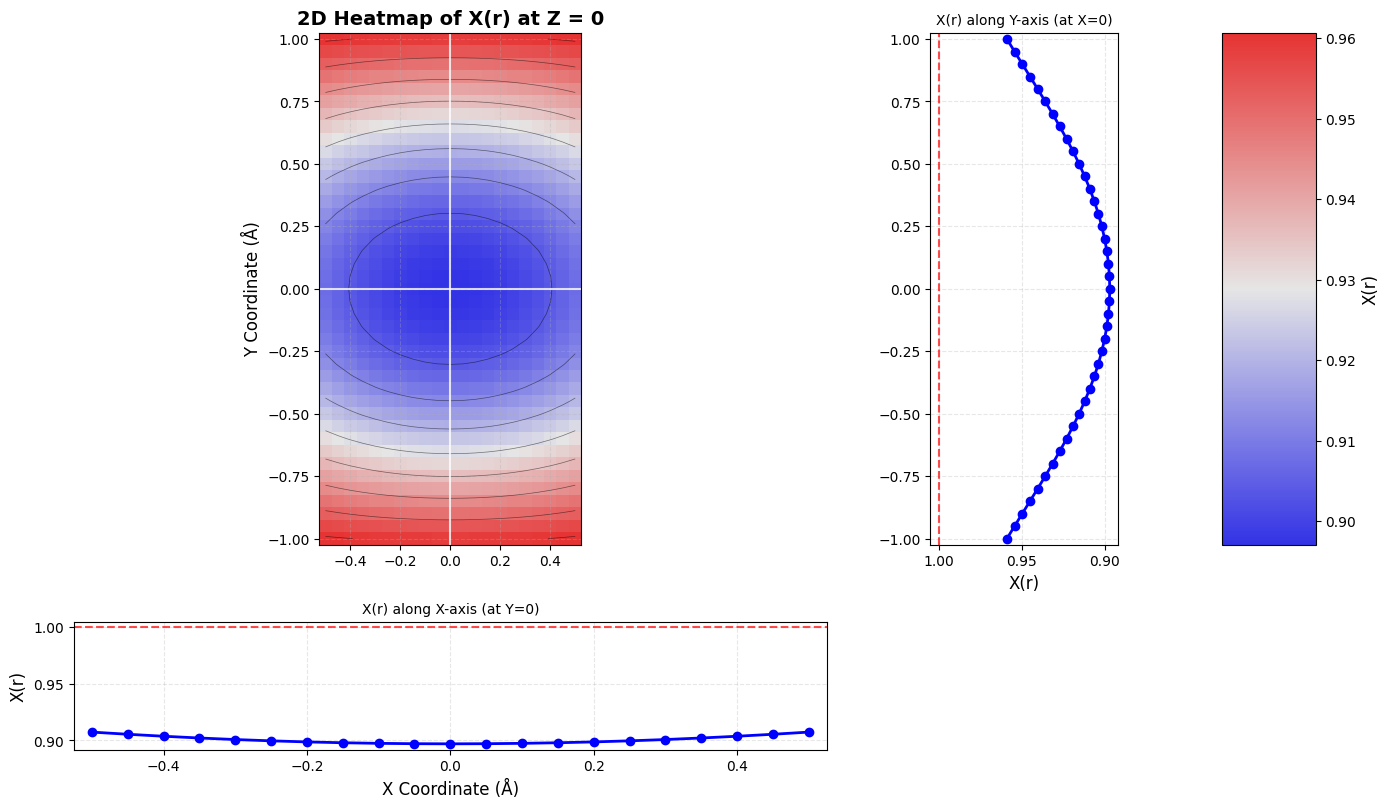

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

def plot_xr_with_profiles(df):
    """
    Create a 2D heatmap of X(r) or other property with cross-section plots along x and y axes.

    Parameters:
    -----------
    data_path : str or pandas.DataFrame, optional
        Path to data file (CSV, Excel, etc.) or pandas DataFrame containing 'x', 'y', 'z' and property columns.
        If None, sample data will be used.
    z_value : float, optional
        Value of z to filter by (plot will show a single z-plane)
    'X(r)' : str, optional
        Column name of the property to plot. Default is 'X(r)'

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure object
    """
    # Load data or use provided sample


    # Filter data for a specific z-value
    filtered_df = df[np.isclose(df['z'],0)]

    if filtered_df.empty:
        raise ValueError(f"No data points found at z={0}")

    # Get unique x and y values and sort them
    x_values = sorted(filtered_df['x'].unique())
    y_values = sorted(filtered_df['y'].unique())

    # Create a grid for the heatmap
    X, Y = np.meshgrid(x_values, y_values)

    # Initialize a 2D array for the property values
    Z = np.zeros_like(X)
    Z_mask = np.ones_like(X, dtype=bool)  # Mask for missing values

    # Fill in the property values
    for _, row in filtered_df.iterrows():
        x_idx = x_values.index(row['x'])
        y_idx = y_values.index(row['y'])
        Z[y_idx, x_idx] = row['X(r)']
        Z_mask[y_idx, x_idx] = False

    # Apply mask for missing values
    Z_masked = np.ma.array(Z, mask=Z_mask)

    # Create custom colormap - adjust this for your specific needs
    colors = [(0.2, 0.2, 0.9), (0.9, 0.9, 0.9), (0.9, 0.2, 0.2)]  # blue -> white -> red

    # Determine appropriate colormap based on property
        # For X(r), values around 1.0 are significant
# Adjust upper bound

    # Create a custom colormap centered at 1.0
    cmap = LinearSegmentedColormap.from_list('X(r)_cmap', colors)

    # Normalize colormap so that center_value is at the middle


    # Extract profile data for x=0 and y=0
    x_profile = filtered_df[np.isclose(filtered_df['x'], 0.0)].sort_values('y')
    y_profile = filtered_df[np.isclose(filtered_df['y'], 0.0)].sort_values('x')

    # Create the figure with a grid layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 4, 1], width_ratios=[4, 1, 0.5])

    # Main heatmap (middle panel)
    ax_main = fig.add_subplot(gs[1, 0])

    # X profile (bottom panel)
    ax_x_profile = fig.add_subplot(gs[2, 0], sharex=ax_main)

    # Y profile (right panel)
    ax_y_profile = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # Colorbar
    ax_colorbar = fig.add_subplot(gs[1, 2])

    # Plot the heatmap
    im = ax_main.pcolormesh(X, Y, Z_masked, cmap=cmap, shading='auto')

    # Add contour lines (optional)
    contour = ax_main.contour(X, Y, Z_masked, colors='black', alpha=0.5, linewidths=0.5)

    # Add reference contour for X(r) = 1.0 if plotting X(r)
    if 'X(r)' == 'X(r)':
        ref_contour = ax_main.contour(X, Y, Z_masked, levels=[1.0], colors='white',
                                    linestyles='dashed', linewidths=2)
        ax_main.clabel(ref_contour, inline=True, fontsize=10, fmt='X(r)=1.0')

    # Add lines indicating the cross-sections
    ax_main.axhline(y=0, color='white', linestyle='-', linewidth=1.5, alpha=0.8)
    ax_main.axvline(x=0, color='white', linestyle='-', linewidth=1.5, alpha=0.8)

    # X-profile (bottom plot)
    ax_x_profile.plot(y_profile['x'], y_profile['X(r)'], 'o-', color='blue', linewidth=2)
    ax_x_profile.set_xlabel('X Coordinate (Å)', fontsize=12)
    ax_x_profile.set_ylabel('X(r)', fontsize=12)
    ax_x_profile.set_title(f"{'X(r)'} along X-axis (at Y=0)", fontsize=10)
    ax_x_profile.grid(True, linestyle='--', alpha=0.3)

    # Add reference line at y=1.0 for X(r)
    if 'X(r)' == 'X(r)':
        ax_x_profile.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)

    # Y-profile (right plot)
    ax_y_profile.plot(x_profile['X(r)'], x_profile['y'], 'o-', color='blue', linewidth=2)
    ax_y_profile.set_xlabel('X(r)', fontsize=12)
    ax_y_profile.set_title(f"{'X(r)'} along Y-axis (at X=0)", fontsize=10)
    ax_y_profile.grid(True, linestyle='--', alpha=0.3)

    # Add reference line at x=1.0 for X(r)
    if 'X(r)' == 'X(r)':
        ax_y_profile.axvline(x=1.0, color='red', linestyle='--', alpha=0.7)

    # Invert the x-axis for the y-profile to match the orientation of the heatmap
    ax_y_profile.invert_xaxis()

    # Add colorbar
    cbar = fig.colorbar(im, cax=ax_colorbar)
    cbar.set_label('X(r)', fontsize=12)

    # Set equal aspect ratio for main plot
    ax_main.set_aspect('equal')

    # Add labels for main plot
    ax_main.set_ylabel('Y Coordinate (Å)', fontsize=12)
    ax_main.set_title(f"2D Heatmap of {'X(r)'} at Z = 0", fontsize=14, fontweight='bold')

    # Hide x-label of main plot (redundant with x-profile)
    ax_main.set_xlabel('')

    # Add grid to main plot
    ax_main.grid(True, linestyle='--', alpha=0.3)

    # Adjust spacing
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    return fig

# Example usage
if __name__ == "__main__":
    # Example with sample data
    fig = plot_xr_with_profiles(results['cube_df'])
    plt.show()

    # Example to plot density instead of X(r)
    # fig = plot_xr_with_profiles('X(r)'='density')
    # plt.show()

    # With custom data
    # df = pd.read_csv('your_data.csv')
    # fig = plot_xr_with_profiles(df, z_value=0.0)
    # plt.savefig('xr_complete_visualization.png', dpi=300, bbox_inches='tight')

In [17]:
def run_casscf_calculation():
    # Define scanning properties for y and z directions
    input = {
    "molecule": "butadiene",
    "method": "CISD",
    "basis": '6-311G*',
    "max_workers": 6,
    "grid": {'x':(3,0.1), 'y':(2,0.1), 'z':(0.0,0.0)},
    "properties": ['otr']
}

    # Run calculation for CASSCF(2,2) with scanning properties
    results = run_calculation(input)

    return results

In [ ]:
results_butadiene = run_casscf_calculation()